In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

import cv2
import time
import numpy as np
import math
import functions as fct
from navigation import *
from obstacleDetection import *
import global_navigation as gn
from IPython.display import clear_output
import pyvisgraph as vg

In [2]:
%%run_python
a_STATE = 0 # current state
a_prox_sum = 0 # sum of the prox sensors
a_countdown = 0 # current countdown
a_countmax = 200 # time delay / timer_period
a_changeState = False # wether or not the state was changed
a_gc = 0 # global counter for the program
stop_state = True

timer_period[0] = 10

v = 100 # speed 
prox_treshold = 50 # treshold for SUM of proximity sensors

tempL = 0 # temp value for calculating 
tempR = 0

globalL = 0 # global navigation commands
globalR = 0 

def check_state_0():  
    # coming from limbo state (2):
        # go to global state (0) if countdown = 0
        # go to local state (1) if obstacle detected
        # else: decrease countdown
    global a_STATE, a_countdown, leds_top, prox_treshold, prox_horizontal, a_prox_sum
    
    # calculate sum prox
    a_prox_sum = 0
    for i in range(5):
        a_prox_sum = a_prox_sum + prox_horizontal[i]

    if a_countdown <= 0 and a_prox_sum < prox_treshold:  # countdown to 0 and no obstacles
        #leds_top = [32, 0, 0]
        leds_top = [0,0,0]
        a_STATE = 0
        stop()
        return True

    elif a_prox_sum > prox_treshold:  # obstacle detected -> back to local nav
        #leds_top = [0, 32, 0]
        a_STATE = 1
        return True
    
    else:
        a_countdown -= 1
        return False


def check_state_1():  
    # coming from global state (0):
        # go to local if obstacle detected
    global prox_horizontal, a_STATE, leds_top, prox_treshold, a_prox_sum
    
    a_prox_sum = 0
    for i in range(5):
        a_prox_sum = a_prox_sum + prox_horizontal[i]
        
    if a_prox_sum > prox_treshold:  # something nearby
        #leds_top = [0, 32, 0]
        a_STATE = 1
        return True
    
    else:
        return False


def check_state_2(): 
    # coming from local state (1):
        # go to limbo state (2) if nothing nearby, reset counter
    global prox_horizontal, a_STATE, a_countdown, a_countmax, leds_top, prox_treshold, a_prox_sum

    a_prox_sum = 0
    for i in range(5):
        a_prox_sum += prox_horizontal[i]
        
    if a_prox_sum < prox_treshold:  # nothing nearby
        a_countdown = a_countmax
        #leds_top = [0, 0, 32]
        a_STATE = 2
        return True
    
    else:  # something nearby
        return False

def updateSpeed():
    global motor_left_target, motor_right_target, tempL, tempR
    motor_left_target = tempL
    motor_right_target = tempR
    
def go_straight():
    global tempL, tempR
    tempL  += v*2
    tempR  += v*2


def go_right():
    global tempL, tempR
    tempL  += v
    tempR  += 0


def go_left():
    global tempL, tempR
    tempL  += 0
    tempR  += v


def pivot_right():
    global tempL, tempR
    tempL  += v
    tempR  += -v


def pivot_left():
    global tempL, tempR
    tempL  += -v
    tempR  += v


def go_back():
    global tempL, tempR
    tempL  += -v
    tempR  += -v


def stop():
    global motor_left_target, motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
def useGlobalCommands():
    global globalL, globalR, tempL, tempR
    tempL += globalL
    tempR += globalR

def state_0():
    global tempL, tempR, a_changeState
    a_changeState = check_state_1()
    if not a_changeState:
        tempL = 0
        tempR = 0
        useGlobalCommands() # use global commands
        updateSpeed()
        


def state_1():  # local navigation
    global prox_horizontal, tempL, tempR, a_changeState
    a_changeState = check_state_2()
    if not a_changeState:
        LEFT = prox_horizontal[0]
        LEFTCENTER = prox_horizontal[1]
        MID = prox_horizontal[2]
        RIGHTCENTER = prox_horizontal[3]
        RIGHT = prox_horizontal[4]
        
        tempL = 0
        tempR = 0
        
        # detect on the LEFT
        if LEFT != 0: go_right()
        # detect on the RIGHT
        if RIGHT != 0: go_left()
        # in LEFTCENTER
        if LEFTCENTER != 0: pivot_right()
        # detect on the RIGHT
        if RIGHTCENTER != 0: pivot_left()
        # detect in the middle
        if MID != 0: go_back()
        #if MID != 0: pivot_left()
        if LEFTCENTER > RIGHTCENTER: pivot_right()
        if RIGHTCENTER > LEFTCENTER: pivot_left()
            
        updateSpeed()

        
def state_2():
    global tempL, tempR, a_changeState
    a_changeState = check_state_0()
    if not a_changeState:
        tempL = 0
        tempR = 0
        go_straight()
        updateSpeed()


def half_speed():
    global motor_left_target, motor_right_target
    motor_left_target = motor_left_target // 2
    motor_right_target = motor_right_target // 2



@onevent
def timer0():
    global a_gc, a_STATE, stop_state
    if not stop_state:
        a_gc += 1
        if a_STATE == 0:
            state_0()
        elif a_STATE == 1:
            state_1()
        elif a_STATE == 2:
            state_2()
    else:
        stop()

In [ ]:
# Initialization setup
fct.initialization_data("data_map.txt", "data_colors.txt")

In [3]:

# Initialization variables
thymio_connected = True
warp = True
loop_path = True
debug_mode = True
widthImg = 1080
heightImg = 720

keep_same_map = False
ghost = False
pause = False
dt = 0.0
pTime = 0.0
my_print = []
shortest_path = []
polygons = []
goal_pos = [0, 0]
thymio_state = np.matrix([[0.0],[0.0],[0.0],[0.0],[0.0]])    # X, Y, angle, v, v_rot
measures = np.matrix([[0.0],[0.0],[0.0],[0.0],[0.0]])        # X, Y, angle, v, v_rot
measure_cam = np.matrix([[0.0],[0.0],[0.0]])                 # X, Y, angle
measure_rob = np.matrix([[0.0], [0.0]])                      # v, v_rot

# Initialize shape of the map and color tracker
matrix = fct.warp_matrix(widthImg, heightImg, "data_map.txt")
tracker = fct.DetectionThymio("data_colors.txt")

# Initialize Kalaman filter
Kalman = fct.KalmanFilter(dt, thymio_state)

# Initialize PID regulators
PID = PID(Kp=Kp, Ki=Ki, Kd=Kd, sumError=0, subError=0, errorPrev=0, maxSumError=maxSumError)
robot = Robot(x=measure_cam[0], y=measure_cam[1], angle=measure_cam[2], state=GLOBAL)


def open_camera():
    
    # Open camera feed
    cap = cv2.VideoCapture(0)

    # Check if camera opened successfully
    if not cap.isOpened():
        print("Error opening video stream")

    # Set width and height parameters
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, widthImg)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, heightImg)
    
    return cap


@tdmclient.notebook.sync_var
def set_motors(speed_l, speed_r):
    global globalL, globalR
    globalL = -speed_r
    globalR = -speed_l
    #globalL = speed_l
    #globalR = speed_r


@tdmclient.notebook.sync_var
def get_motors():
    global motor_left_speed, motor_right_speed
    forwSpeed = (motor_left_speed + motor_right_speed) / 2.0
    rotSpeed = (motor_left_speed - motor_right_speed) / 2.0
    speed = [forwSpeed, rotSpeed]
    return speed


@tdmclient.notebook.sync_var
def stop_motors():
    global stop_state
    stop_state = True


@tdmclient.notebook.sync_var
def start_motors():
    global stop_state
    stop_state = False


def picture_of_the_map(cap, file_name):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    while True:

        # Getting a frame and warping it
        ret, frame = cap.read()
        mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

        # Show text
        show = mymap.copy()
        show = fct.draw_text(show, 'Push "P" to take a new picture, "Enter" otherwise', (255, 0, 0))

        cv2.imshow("Area", show)

        k = cv2.waitKey(1)  # Enter is pressed

        if k == 13:  # Press Enter to keep the same map
            keep_same_map = True
            break
        if k == ord("p"):  # Press P to save a new map
            cv2.imwrite(file_name, mymap)
            break


def path_planning(cap, file_name):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    while True:

        # Getting a frame and warping it
        ret, frame = cap.read()
        mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

        # Find goal point and Thymio
        goal_pos = fct.find_template('GoalTemplate.png', mymap)
        thymio_visible, measure_cam = tracker.state(mymap)

        # Show Goal
        show = mymap.copy()
        show = fct.draw_goal(show, goal_pos, (0, 255, 255))

        # Show Thymio
        if thymio_visible:
            show = fct.draw_thymio(show, measure_cam, (255, 0, 0))

        show = fct.draw_text(show, 'Push "Enter" to compute the path', (255, 0, 0))
        cv2.imshow("Area", show)

        if 13 == cv2.waitKey(1):  # Enter is pressed
            start_pos = measure_cam
            thymio_state[0] = measure_cam[0]
            thymio_state[1] = measure_cam[1]
            thymio_state[2] = measure_cam[2]
            break

    cv2.destroyAllWindows()

    # Global navigation
    start_point = vg.Point(start_pos[0], start_pos[1])
    goal_point = vg.Point(goal_pos[0], goal_pos[1])

    if not keep_same_map:

        # Map processing
        visualsProfile1()
        settingsProfile1()
        chunkmap, polys, thymiowidth = analysePicture2()

        # Save map
        string = savePoints(chunkmap, polys, thymiowidth)
        text_file = open(file_name, "w")
        text_file.write(string)
        text_file.close()

        # Path planning
        shortest_path, polygons = gn.path_planning(polys, start_point, goal_point, thymiowidth / 1.6, gridMap = chunkmap)
        shortest_path.reverse()
    else:

        # Load map
        text_file = open(file_name, "r")
        string = text_file.read()
        text_file.close()
        thymiowidth, minx, miny, maxx, maxy, polys = getPolys(string)

        # Path planning
        shortest_path, polygons = gn.path_planning(polys, start_point, goal_point, thymiowidth / 1.6, minx = minx, maxx = maxx, miny = miny, maxy = maxy)
        shortest_path.reverse()


def pre_visualisation(cap):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    while True:

        # Getting a frame and warping it
        ret, frame = cap.read()
        mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

        # Get the position
        thymio_visible, measure_cam = tracker.state(mymap)

        # Show obstacles
        show = mymap.copy()
        show = fct.draw_obstacles(show, polygons, (0, 255, 0))

        # Show path
        show = fct.draw_path(show, shortest_path, (0, 0, 255))

        # Show Goal
        show = fct.draw_goal(show, goal_pos, (0, 255, 255))

        # Show Thymio
        if thymio_visible:
            show = fct.draw_thymio(show, measure_cam, (255, 0, 0))

        show = fct.draw_text(show, 'Push "Enter" to start', (255, 0, 0))
        cv2.imshow("Area", show)

        if 13 == cv2.waitKey(1):  # Enter is pressed
            thymio_state = np.append(measure_cam, np.matrix([[0.0], [0.0]]), axis=0)
            start_motors()
            break


def running_loop(cap, video_name):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    out = cv2.VideoWriter(video_name, -1, 20.0, (1080,720))
    
    if len(shortest_path) > 1:
        while True:

            # Getting a frame
            ret, frame = cap.read()
            mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

            # Calculate dt
            cTime = time.time()
            dt = cTime - pTime
            pTime = cTime

            if pause:
                k = cv2.waitKey(1)
                stop_motors()

                # Used to tune the PID and debug
                robot, PID = fct.debug_mode(debug_mode, robot, PID, k)

                if k == ord("p"):
                    pause = False
                    start_motors()
                    dt = 0
                continue

            # Kalman's prediction step and store the print
            thymio_state = Kalman.predict(dt)
            my_print.append(thymio_state[0:2])

            # Motion control
            robot.x = thymio_state[0]
            robot.y = thymio_state[1]
            robot.angle = thymio_state[2]

            # PID controller
            PID, robot, speedL, speedR, target_point = navigation(robot, shortest_path, PID)
            set_motors(speedL, speedR)

            # Get the postition
            thymio_visible, measure_cam = tracker.state(mymap)

            # Get speed
            speed = get_motors()
            measure_rob = np.matrix([[fct.speed_pixel_s(speed[0])],
                                     [fct.rot_speed_deg_s(speed[1])]])

            measures = np.append(measure_cam, measure_rob, axis=0)

            # Kalman update step
            if ghost:
                thymio_visible = False
            Kalman.update(thymio_visible, thymio_connected, measures)

            # Drawings
            show = mymap.copy()

            # Show FPS
            show = fct.draw_fps(show, dt)

            # Show path
            show = fct.draw_path(show, shortest_path, (0, 0, 255))
            show = fct.draw_cam_statu(show, thymio_visible)

            # Show my print
            show = fct.draw_my_print(show, my_print, (0, 255, 255))

            # Show thymio position measure if visible
            if thymio_visible:
                show = fct.draw_point(show, measure_cam, (0, 255, 0))

            # Show thymio position and angle Filtered
            show = fct.draw_thymio(show, thymio_state, (255, 0, 0))

            # Show Goal
            show = fct.draw_goal(show, goal_pos, (0, 255, 255))

            # Show target point
            show = fct.draw_point(show, [target_point.x, target_point.y], (255, 0, 0))

            cv2.imshow("Area", show)
            out.write(show)

            k = cv2.waitKey(1)  # Press G to run without the cam
            if k == ord("g"):
                if ghost:
                    ghost = False
                else:
                    ghost = True

            if k == ord("p"):  # Press P to pause the run
                pause = True

            if loop_path:
                if k == ord("q"): # Press q to quit the run
                    set_motors(0, 0)
                    break  

                if robot.state == STOP:
                    shortest_path.reverse()
                    robot.pathCount = 0
                    robot.state = GLOBAL
            else:
                if k == ord("q") or robot.state == STOP:  # Press q to quit the run
                    set_motors(0, 0)
                    break
                

        cap.release()
        out.release()
        stop_motors()


(0, 0, 1080, 720)


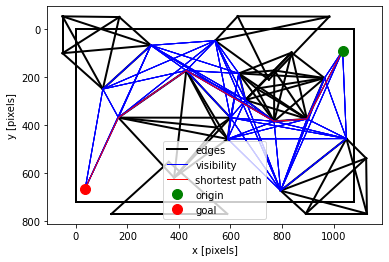

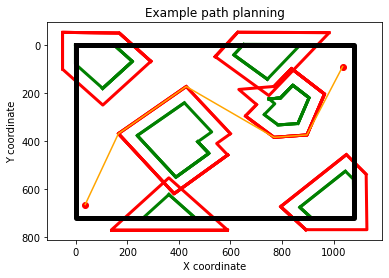

In [ ]:

# Open camera
cap = open_camera()

# Picture of the map
picture_of_the_map(cap, "map_without_thymio.png")

# Path planning
path_planning(cap, "map_save.txt")

# Pre visualization before start
pre_visualisation(cap)

# Running of the thymio on the map
running_loop(cap, 'video_thymio_demo5.mp4')
                    


In [ ]:
cap.release()

In [ ]:
cv2.destroyAllWindows()